## Land Use Classification | CNN Model

 simple convolutional neural network model and a tranfer learning model based on ImageNet's VGG16 model.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import shutil
import itertools
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras import models
from keras import backend as K
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.metrics import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix

%matplotlib inline

Using TensorFlow backend.


In [ ]:
# set up reproducible environment
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed = 123
random.seed(456)
tf.set_random_seed(789)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

### Data Preparation


In [ ]:
base_path = '/Users/limesncoconuts2/datasets'
train_path = os.path.join(base_path, 'land-use-jpeg/train')
valid_path = os.path.join(base_path, 'land-use-jpeg/valid')
test_path = os.path.join(base_path, 'land-use-jpeg/test')

In [ ]:
categories = []
for (dirpath, dirnames, filenames) in os.walk(os.path.join(base_path, 'land-use-tif')):
    categories.extend(dirnames)

In [ ]:
for category in categories:
    tr = os.path.join(train_path, category)
    len_tr = len(os.listdir(tr))

    val = os.path.join(valid_path, category)
    len_val = len(os.listdir(val))

    test = os.path.join(test_path, category)
    len_test = len(os.listdir(val))

    print('Train images for ' + category + ': {}'.format(len_tr))
    print('Validation images for ' + category + ': {}'.format(len_val))
    print('Test images for ' + category + ': {}'.format(len_test))
    print('')

Train images for Forest: 2400
Validation images for Forest: 300
Test images for Forest: 300

Train images for River: 2000
Validation images for River: 250
Test images for River: 250

Train images for Highway: 2000
Validation images for Highway: 250
Test images for Highway: 250

Train images for AnnualCrop: 2400
Validation images for AnnualCrop: 300
Test images for AnnualCrop: 300

Train images for SeaLake: 2400
Validation images for SeaLake: 300
Test images for SeaLake: 300

Train images for HerbaceousVegetation: 2400
Validation images for HerbaceousVegetation: 300
Test images for HerbaceousVegetation: 300

Train images for Industrial: 2000
Validation images for Industrial: 250
Test images for Industrial: 250

Train images for Residential: 2400
Validation images for Residential: 300
Test images for Residential: 300

Train images for PermanentCrop: 2000
Validation images for PermanentCrop: 250
Test images for PermanentCrop: 250

Train images for Pasture: 1600
Validation images for Pastu

In [ ]:
train_batches = ImageDataGenerator().flow_from_directory(train_path,
                                                         target_size=(64, 64),
                                                         classes=categories,
                                                         batch_size=20)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(64, 64),
                                                         classes=categories,
                                                         batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path,
                                                         target_size=(64, 64),
                                                         classes=categories,
                                                         batch_size=10,
                                                         shuffle=False)


Found 21600 images belonging to 10 classes.
Found 2700 images belonging to 10 classes.
Found 2700 images belonging to 10 classes.


In [ ]:
# plots images with labels within jupyter notebook
# from Github / YouTube user deeplizard: https://www.youtube.com/watch?v=LhEMXbjGV_4
def plots(ims, figsize=(30, 15), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims) //rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.tight_layout()
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [ ]:
imgs, labels = next(train_batches)

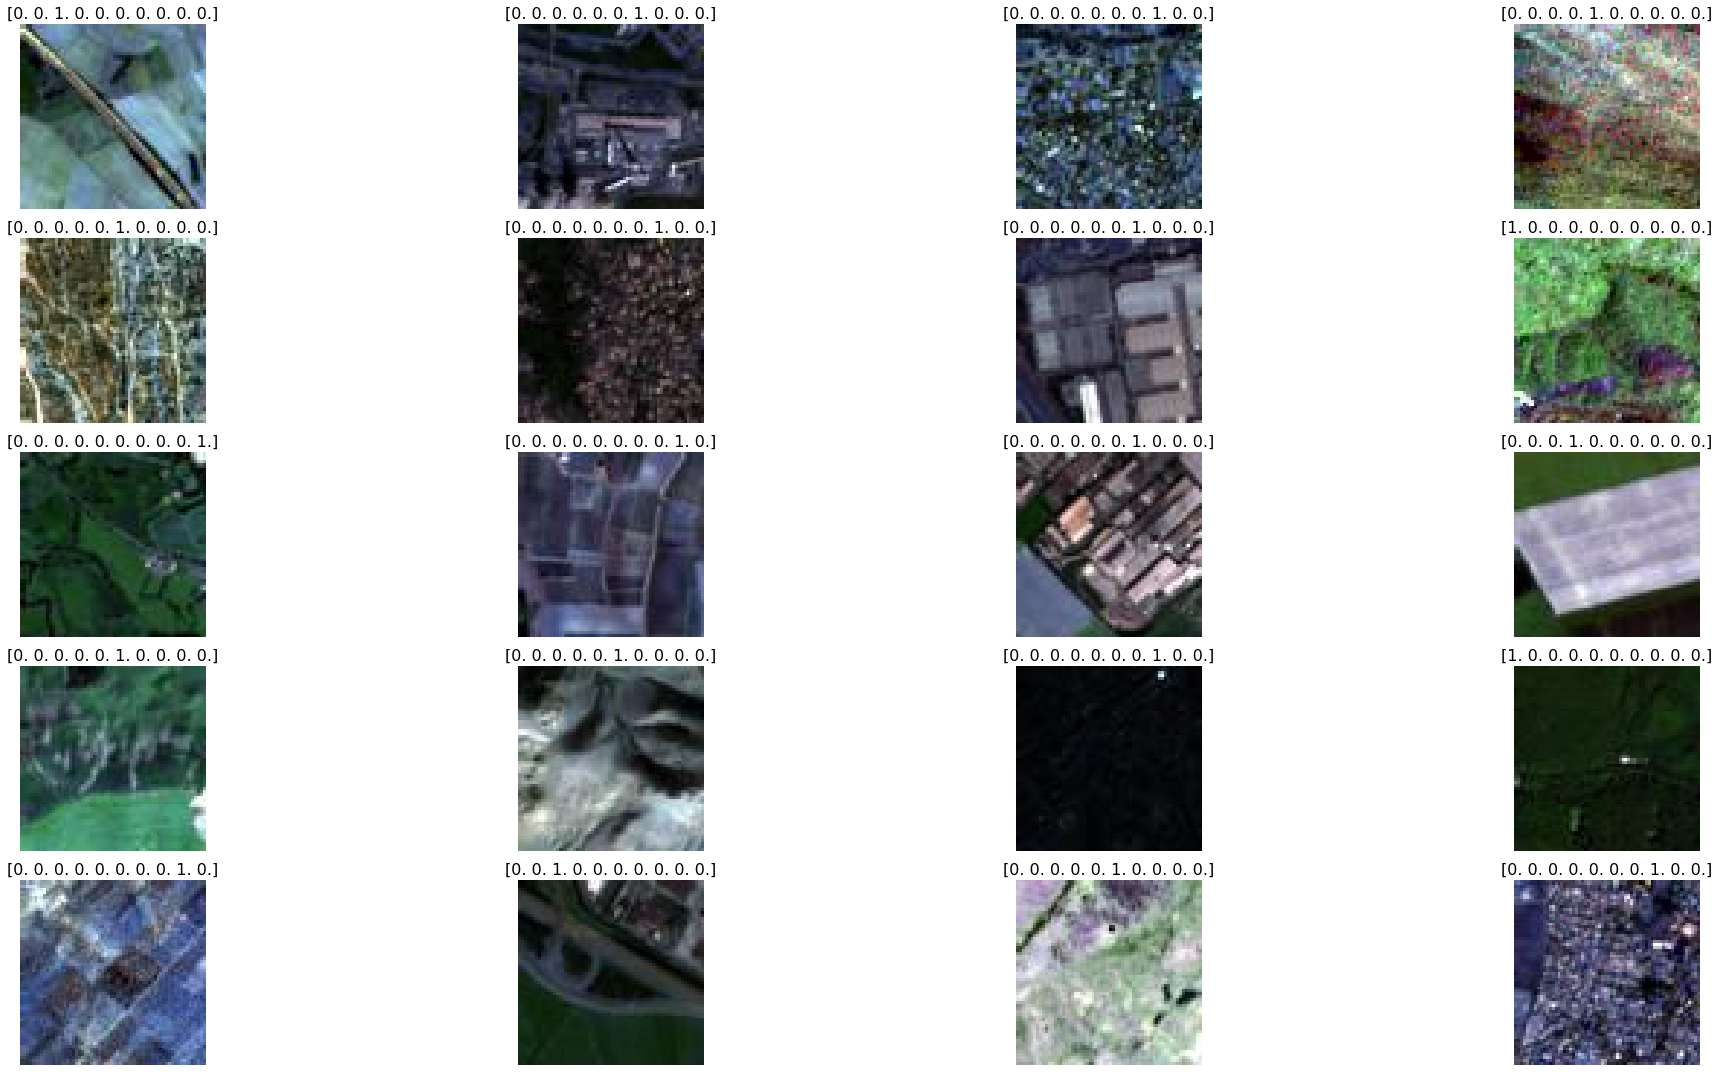

In [ ]:
plots(imgs, rows=5, titles=labels)

### Building and training the simple CNN


In [ ]:
model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64,64,3)), # convolutions
        Flatten(), # flatten into 1-D tensor
        Dense(10, activation='softmax') #output layer that categorizes images
])

In [ ]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
# fits the model on data generated batch by batch by ImageDataGenerator
model.fit_generator(train_batches, steps_per_epoch=1080,
                   validation_data=valid_batches, validation_steps=270,
                   epochs=5,
                   verbose=2)

Epoch 1/5
 - 139s - loss: 14.3266 - acc: 0.1111 - val_loss: 14.3272 - val_acc: 0.1111
Epoch 2/5
 - 157s - loss: 14.3294 - acc: 0.1110 - val_loss: 14.3272 - val_acc: 0.1111
Epoch 3/5
 - 148s - loss: 14.3279 - acc: 0.1111 - val_loss: 14.3272 - val_acc: 0.1111
Epoch 4/5
 - 150s - loss: 14.3235 - acc: 0.1113 - val_loss: 14.3272 - val_acc: 0.1111
Epoch 5/5
 - 167s - loss: 14.3287 - acc: 0.1110 - val_loss: 14.3272 - val_acc: 0.1111
CPU times: user 16min 30s, sys: 1min 12s, total: 17min 42s
Wall time: 12min 41s


### Predicting on the test set

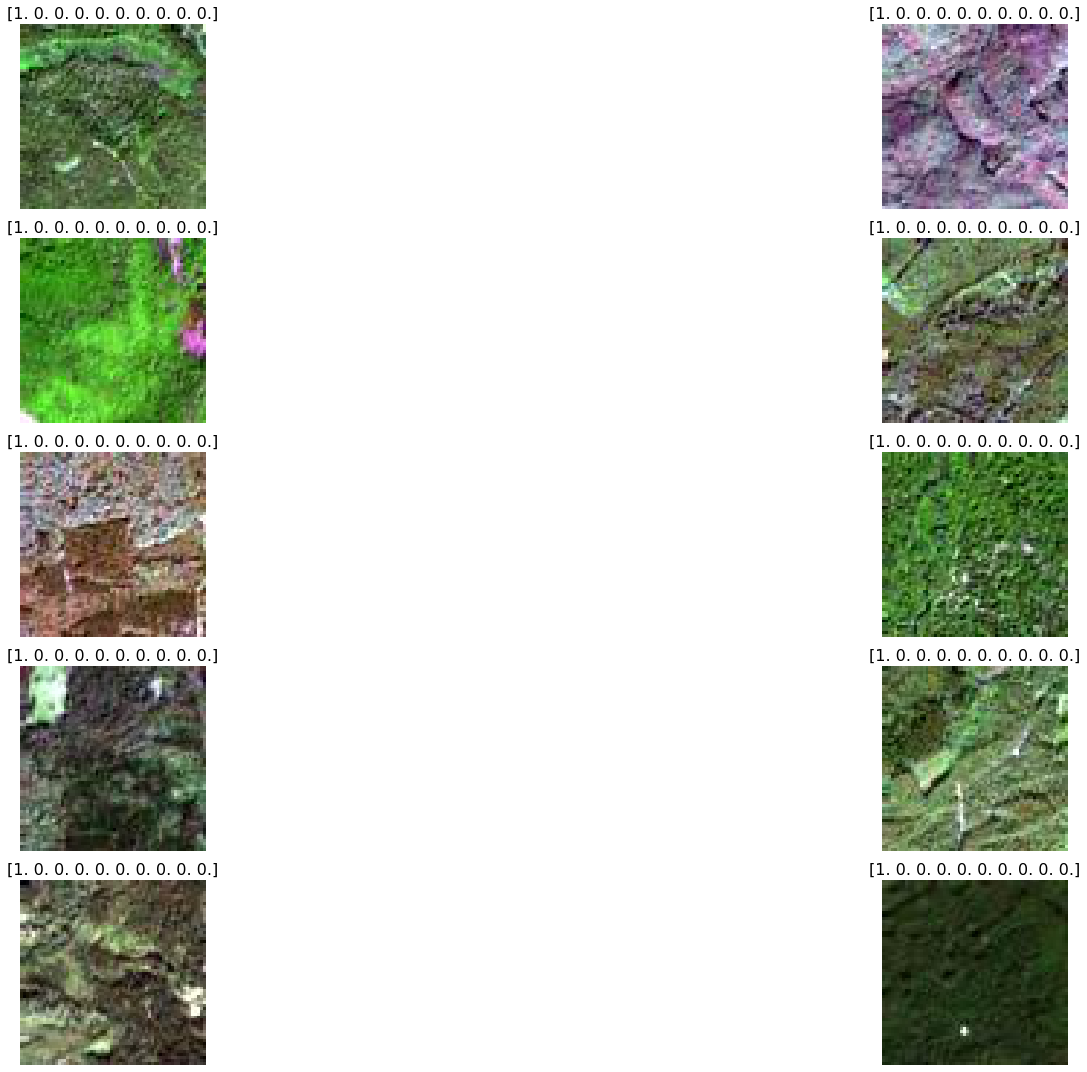

In [ ]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, rows=5, titles=test_labels)

In [ ]:
test_labels = test_batches.classes
test_labels

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [ ]:
# get the assigned class labels
test_batches.class_indices

{'Forest': 0,
 'River': 1,
 'Highway': 2,
 'AnnualCrop': 3,
 'SeaLake': 4,
 'HerbaceousVegetation': 5,
 'Industrial': 6,
 'Residential': 7,
 'PermanentCrop': 8,
 'Pasture': 9}

In [ ]:
predictions = model.predict_generator(test_batches, steps=270, verbose=0)

In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
# modified from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes
              )
    if normalize:
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

Confusion matrix, without normalization
[[  0   0   0   0   0   0   0 300   0   0]
 [  0   0   0   0   0   0   0 250   0   0]
 [  0   0   0   0   0   0   0 250   0   0]
 [  0   0   0   0   0   0   0 300   0   0]
 [  0   0   0   0   0   0   0 300   0   0]
 [  0   0   0   0   0   0   0 300   0   0]
 [  0   0   0   0   0   0   0 250   0   0]
 [  0   0   0   0   0   0   0 300   0   0]
 [  0   0   0   0   0   0   0 250   0   0]
 [  0   0   0   0   0   0   0 200   0   0]]


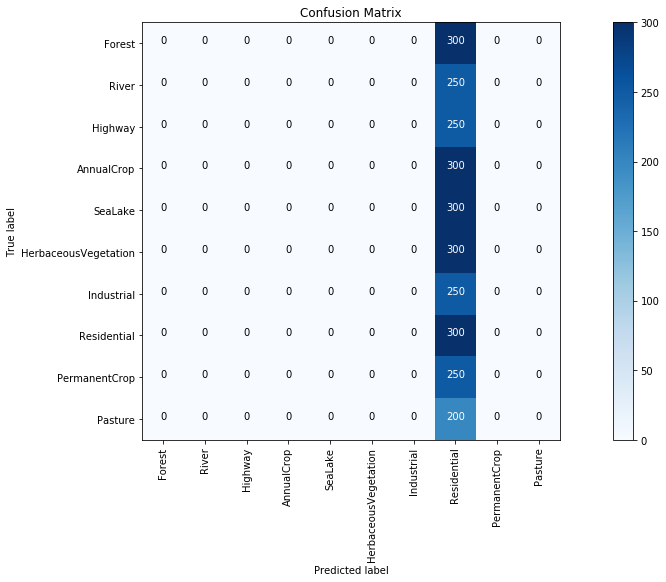

In [ ]:
plot_confusion_matrix(cm, categories, title='Confusion Matrix')

### Building a CNN using transfer learning


In [ ]:
vgg16_model = keras.applications.vgg16.VGG16(include_top=False, input_shape=(64,64,3))

In [ ]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

The model needs to be modified to fit the 10 different categories in this project.

In [ ]:
# VGG16 model is type Model from the keras functional API
type(vgg16_model)

keras.engine.training.Model

In [ ]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [ ]:
# this sequential model is now the same architecture as the VGG16 model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)       295168    
__________

In [ ]:
# train a certain number of layers to learn about the type of data we're using,
# which is much different than for imagenet
NUM_TRAINABLE_LAYERS = 10
for layer in model.layers[:-NUM_TRAINABLE_LAYERS]:
    layer.trainable = False #excludes layer from future training so weights will not be updated when we train the model on our own data

In [ ]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(categories), activation='softmax'))

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)       295168    
__________

### Training the transfer CNN model


In [ ]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
history = model.fit_generator(train_batches, steps_per_epoch=1080,
                   validation_data=valid_batches, validation_steps=270,
                   epochs=10,
                   verbose=2)

Epoch 1/10
 - 3876s - loss: 0.5363 - acc: 0.8406 - val_loss: 0.3991 - val_acc: 0.8778
Epoch 2/10
 - 15443s - loss: 0.2364 - acc: 0.9280 - val_loss: 0.2777 - val_acc: 0.9230
Epoch 3/10
 - 3804s - loss: 0.1811 - acc: 0.9460 - val_loss: 0.2599 - val_acc: 0.9244
Epoch 4/10
 - 6885s - loss: 0.1523 - acc: 0.9555 - val_loss: 0.2207 - val_acc: 0.9344
Epoch 5/10
 - 4585s - loss: 0.1168 - acc: 0.9646 - val_loss: 0.2540 - val_acc: 0.9263
Epoch 6/10
 - 4209s - loss: 0.0976 - acc: 0.9714 - val_loss: 0.2391 - val_acc: 0.9437
Epoch 7/10
 - 6050s - loss: 0.0977 - acc: 0.9710 - val_loss: 0.3614 - val_acc: 0.9211
Epoch 8/10
 - 23772s - loss: 0.0890 - acc: 0.9761 - val_loss: 0.2184 - val_acc: 0.9415
Epoch 9/10
 - 9429s - loss: 0.0663 - acc: 0.9821 - val_loss: 0.2188 - val_acc: 0.9511
Epoch 10/10
 - 46819s - loss: 0.0766 - acc: 0.9783 - val_loss: 0.2226 - val_acc: 0.9444
CPU times: user 10h 2min 56s, sys: 41min 26s, total: 10h 44min 23s
Wall time: 1d 10h 41min 14s


### Predicting on the test set


In [ ]:
test_labels = test_batches.classes
test_labels

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [ ]:
test_batches.class_indices

{'Forest': 0,
 'River': 1,
 'Highway': 2,
 'AnnualCrop': 3,
 'SeaLake': 4,
 'HerbaceousVegetation': 5,
 'Industrial': 6,
 'Residential': 7,
 'PermanentCrop': 8,
 'Pasture': 9}

In [ ]:
predictions = model.predict_generator(test_batches, steps=270, verbose=0)

Confusion matrix, without normalization
[[180 103  15   0   0   1   0   1   0   0]
 [  1 121 123   2   0   2   0   0   1   0]
 [  0   1 127 114   1   0   0   1   4   2]
 [  0   1   2 174 116   0   1   0   4   2]
 [  3   1   5   2 175 113   0   0   1   0]
 [  3   0   5   0   1 169 112   2   8   0]
 [  0   0   5   0   0   0 124 119   2   0]
 [  0   1   2   7   0   9   0 178 103   0]
 [  4   0   2   6   1  18   4   0 105 110]
 [121   0   0   0   0   2   0   0   1  76]]


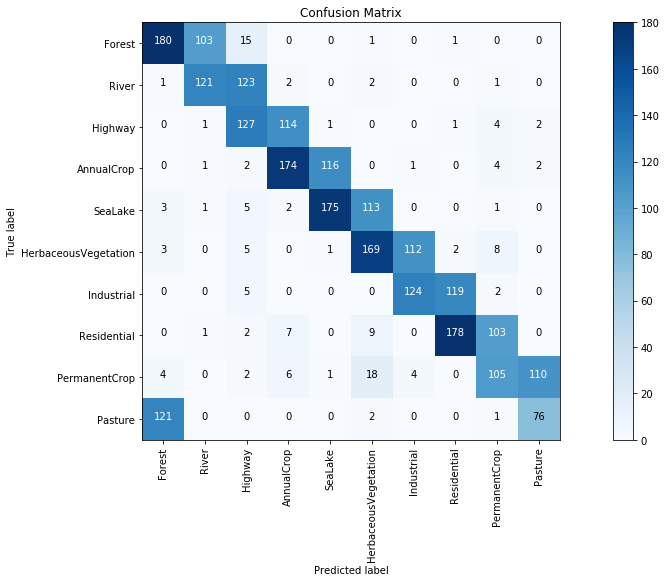

In [ ]:
# confusion matrix using the results of the model on the test set
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
plot_confusion_matrix(cm, categories, title='Confusion Matrix')

In [ ]:
# save trained model, including weights
model.save('land_use_model.h5')

### Model Loss and Accuracy

Loss and accuracy of the model over the training and validation data during training. ([source](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb))

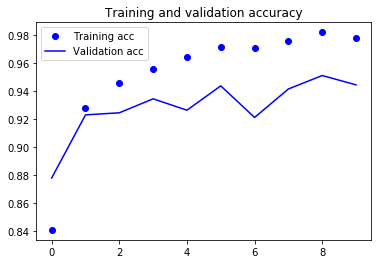

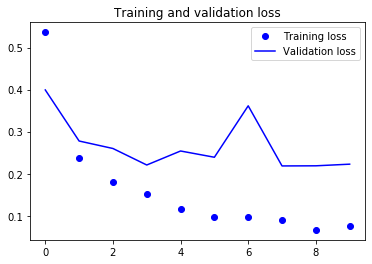

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Images at Intermediate Layers
([source](https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md))

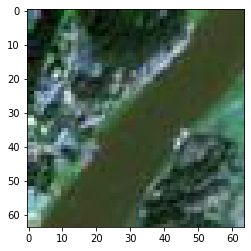

(1, 64, 64, 3)


In [ ]:
img_path = test_path + '/River/River_6.jpeg'

img = image.load_img(img_path, target_size=(64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(img_tensor.shape)

In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict_classes(images, batch_size=10)
print("Predicted class is:",classes)

Predicted class is: [1]


In [ ]:
layer_outputs = [layer.get_output_at(-1) for layer in model.layers[:10]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [ ]:
activations = activation_model.predict(img_tensor)

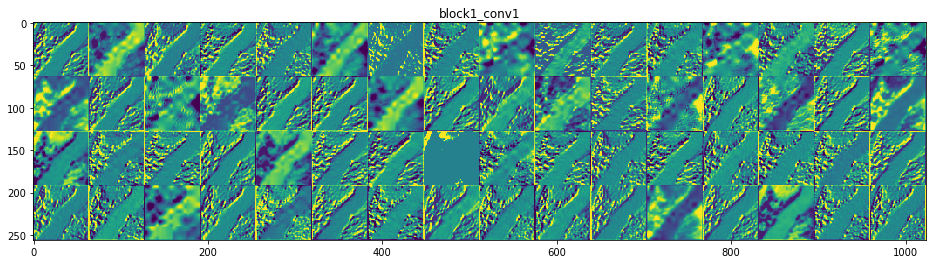

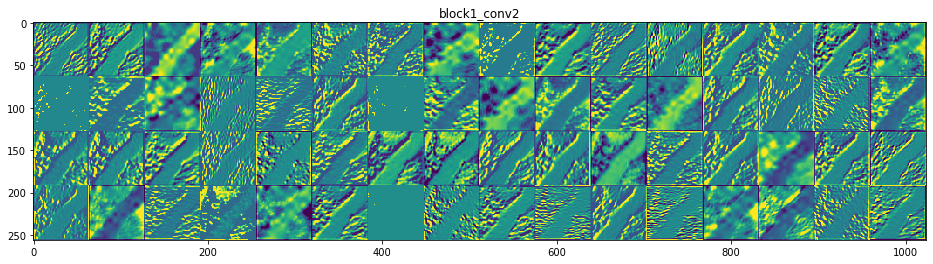

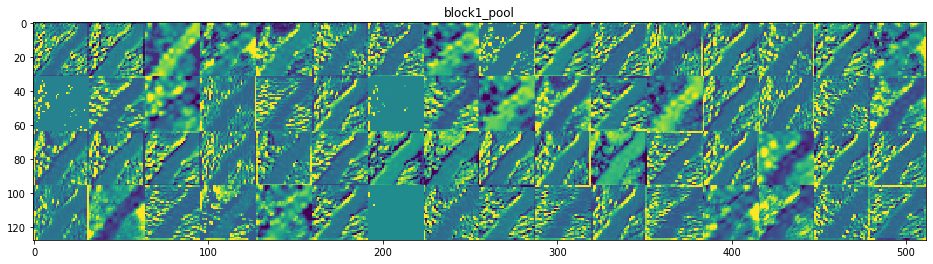

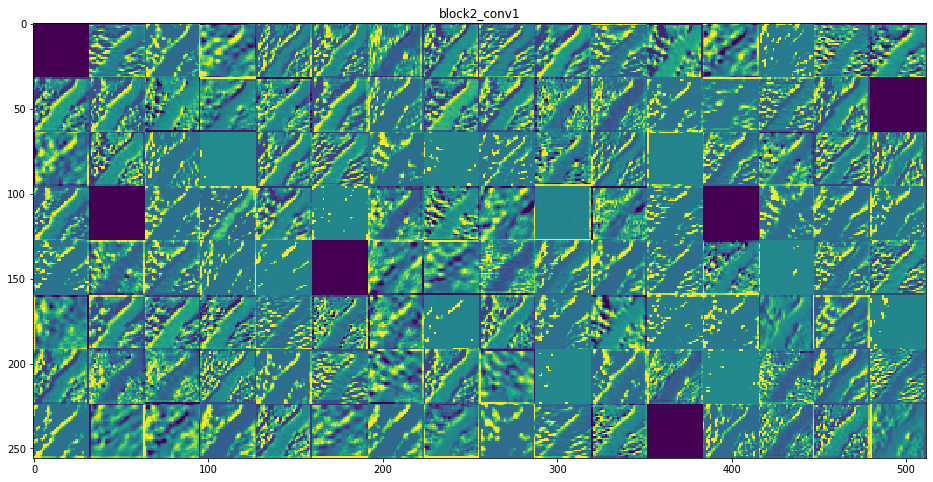

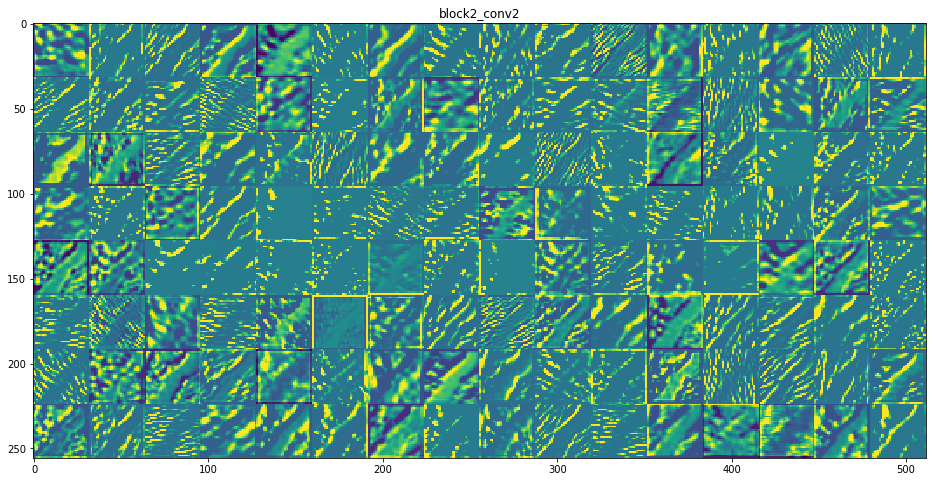

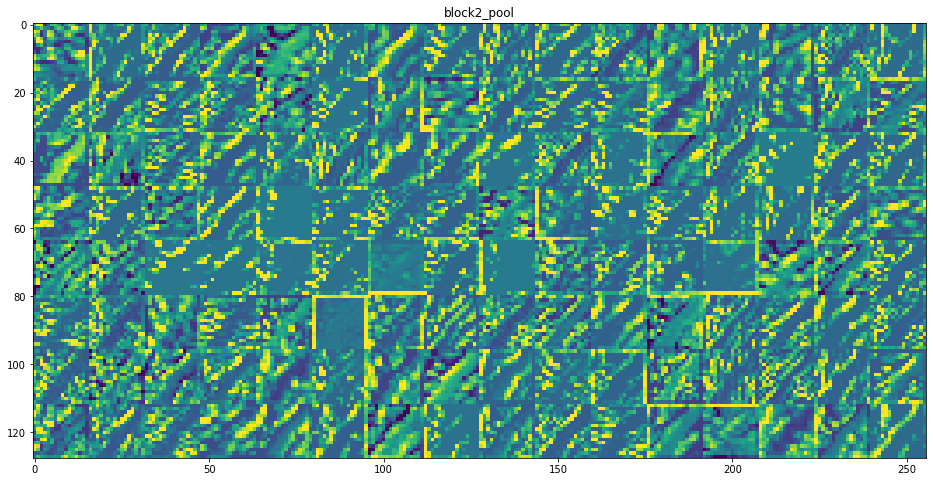

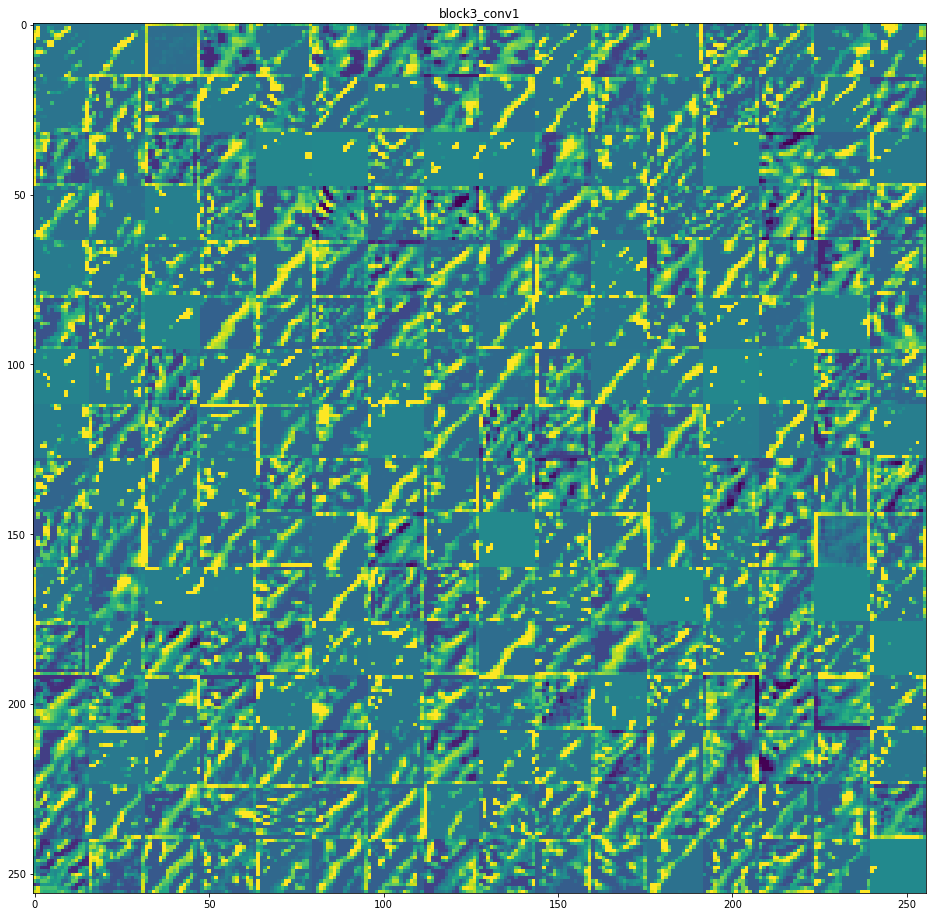

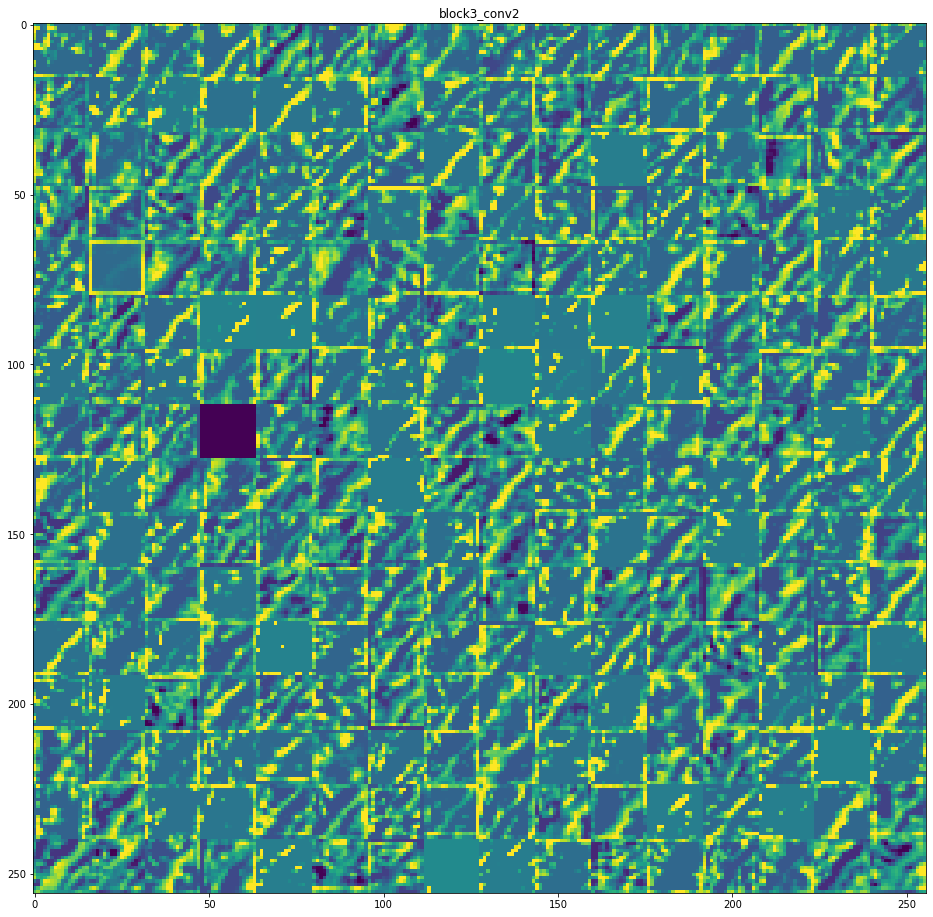

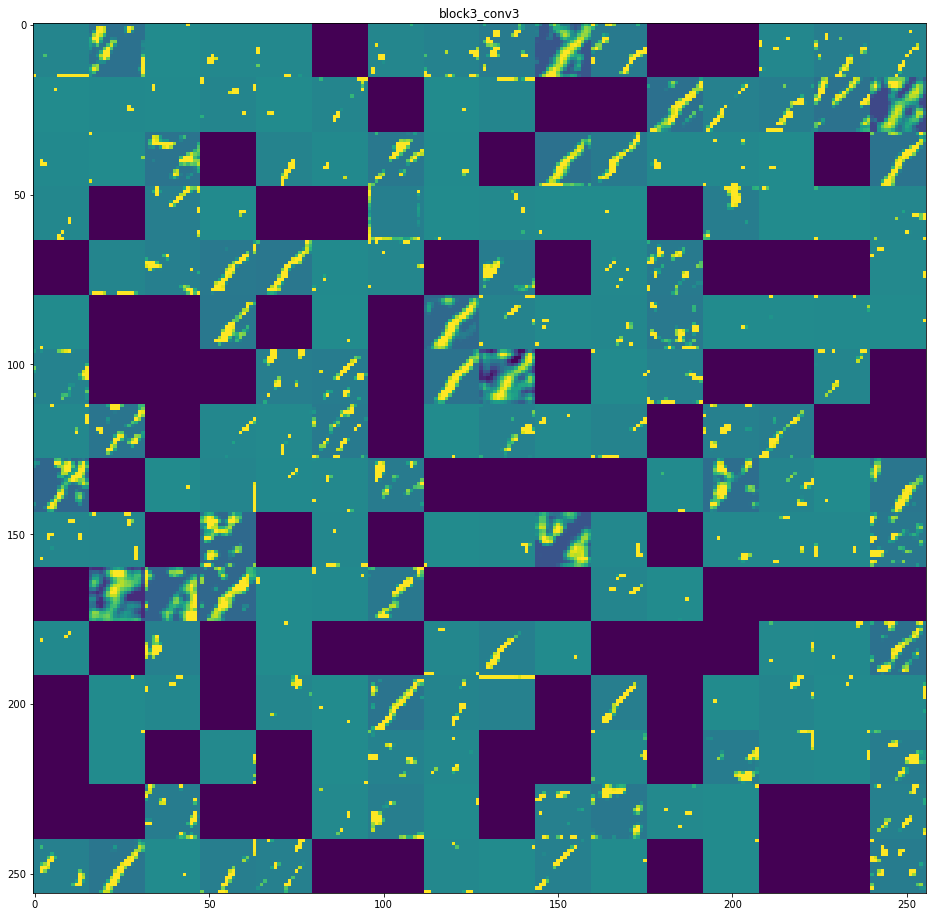

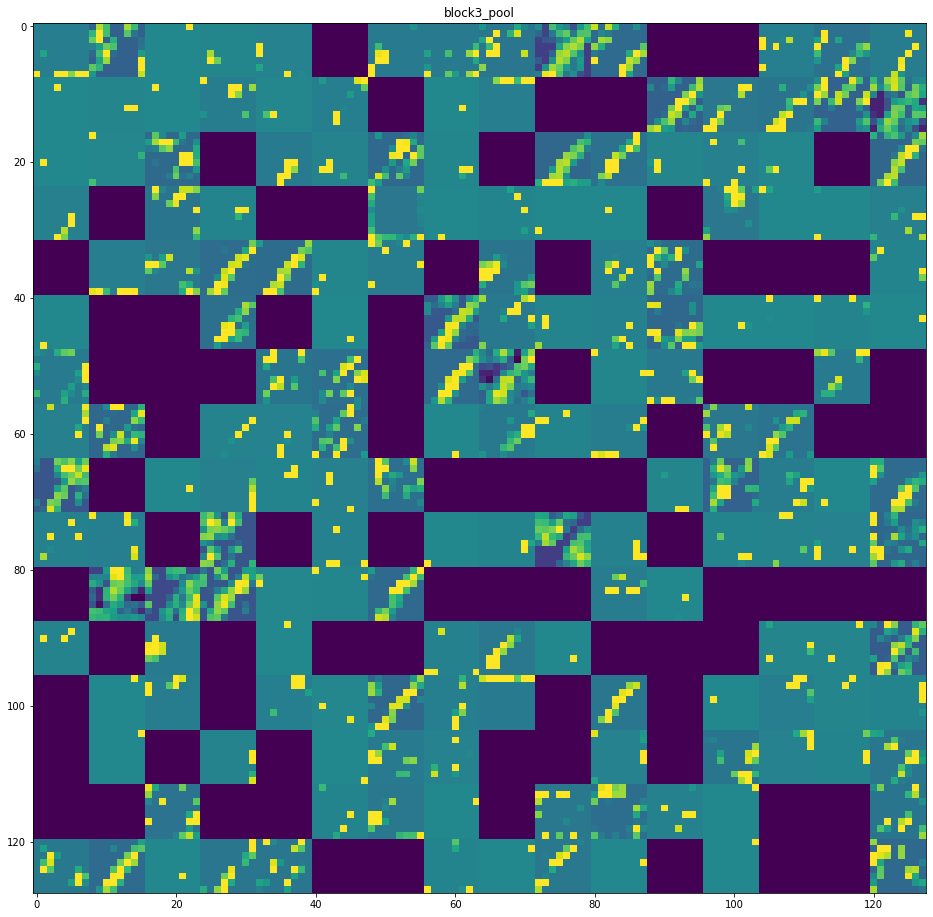

In [ ]:
layer_names = []
for layer in model.layers[:10]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')